In [1]:
push!(LOAD_PATH, "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code")

3-element Array{ByteString,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.4"     
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.4"           
 "/Users/farr/Documents/Research/GaussianNoiseModeling/PopeFilters/code"

In [2]:
using Ensemble
using Kalman
using PyCall
using PyPlot

In [3]:
@pyimport corner
@pyimport seaborn as sns
sns.set_style("ticks")

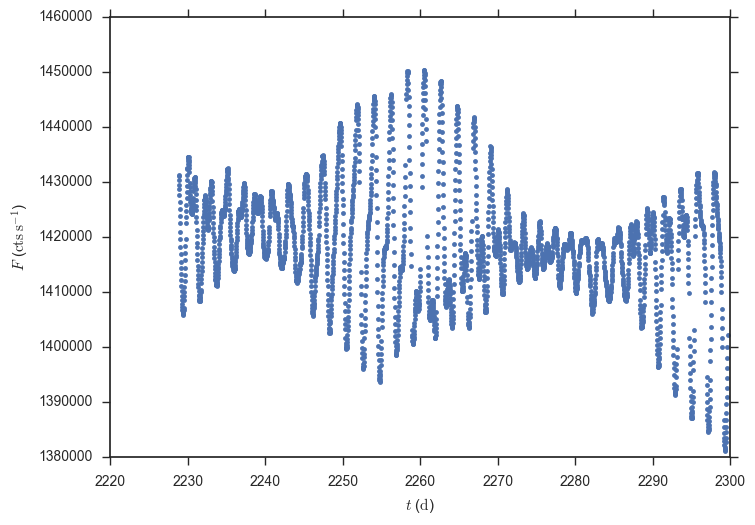

PyObject <matplotlib.text.Text object at 0x32bcccb90>

In [4]:
data = readdlm("../epic210969800.txt")
errorbar(data[:,1], data[:,2], data[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{d}$)")
ylabel(L"$F$ ($\mathrm{cts} \, \mathrm{s}^{-1}$)")

In [5]:
post = Kalman.CARMAKalmanPosterior(data[:,1], data[:,2], data[:,3], 3, 2)
function logpost(x)
    lp = Kalman.log_prior(post, x)
    if lp == -Inf
        lp
    else
        lp + Kalman.log_likelihood(post, x)
    end
end

logpost (generic function with 1 method)

In [6]:
pts = Kalman.init(post, 128)
lnprobs = EnsembleSampler.lnprobs(pts, logpost)

128-element Array{Float64,1}:
 -41945.2      
 -62056.0      
 -35916.0      
 -25517.0      
     -4.08674e7
     -4.7375e7 
     -5.34167e5
 -44540.5      
 -31295.0      
 -34304.1      
     -2.8481e7 
     -1.85556e6
 -49191.9      
      ⋮        
     -1.34875e5
     -1.285e6  
 -29816.5      
     -6.25265e6
 -29948.4      
 -65657.0      
 -67040.4      
     -2.07928e6
     -1.69e5   
 -77016.3      
 -45134.6      
     -3.74378e6

In [7]:
ps_save = nothing
lnps_save = nothing

In [8]:
function neff_cb(ps, lnps, n, thin)
    println("Iterated by $(n)")
    println("  (max, mean, var)(log(L)) = $((maximum(lnps), mean(lnps), var(lnps)))")
    println("  max ACL = $(maximum(Acor.acl(ps)))")
    ps_save = ps
    lnps_save = lnps
end
@time ens, enslnps = EnsembleSampler.run_to_neff(pts, lnprobs, logpost, 16, callback=neff_cb)

Iterated by 128
  (max, mean, var)(log(L)) = (-21153.13147692399,-1.4257865329221431e6,4.643237346406703e15)
  max ACL = Inf
Iterated by 128
  (max, mean, var)(log(L)) = (-21082.43954426243,-21574.934408668218,555947.2682454146)
  max ACL = Inf
Iterated by 128
  (max, mean, var)(log(L)) = (-21040.562828933766,-21317.238220444808,334987.40247866197)
  max ACL = Inf
Iterated by 128
  (max, mean, var)(log(L)) = (-21012.708401071264,-21029.469341050455,92.60424830603714)
  max ACL = Inf
Iterated by 128
  (max, mean, var)(log(L)) = (-21011.638656434814,-21016.880417541608,6.371531188491934)
  max ACL = Inf
Iterated by 256
  (max, mean, var)(log(L)) = (-21011.62914359321,-21015.585643850347,4.223501624118955)
  max ACL = Inf
Iterated by 512
  (max, mean, var)(log(L)) = (-21011.53852763555,-21015.503683155694,4.143543136448006)
  max ACL = Inf
Iterated by 1024
  (max, mean, var)(log(L)) = (-21011.520760118827,-21015.568556392922,4.245965313296669)
  max ACL = 10.582183130320947
Iterated by 20

(
8x128x128 Array{Float64,3}:
[:, :, 1] =
     1.42069e6      1.41604e6      1.41964e6  …      1.41753e6      1.41888e6
 11916.2        10755.9        11894.6           12005.9        11547.0      
     0.64512        0.584016       0.867895          0.904343       0.773515 
     0.351102       0.595708       0.58033           0.438997       0.598434 
     3.11649        2.9741         2.85888           2.9987         3.01701  
     1.14416        1.41085        1.39084    …      0.988568       1.09991  
     3.15257        3.20547        3.26182           3.2486         3.21245  
     6.32672        6.36191        6.41024           6.26178        6.31968  

[:, :, 2] =
     1.41998e6      1.41684e6      1.41908e6  …      1.41809e6      1.41889e6
 12509.3        10282.1        11459.4           12665.2        11755.4      
     0.780701       0.571495       0.790028          0.920748       0.813251 
     0.382263       0.778257       0.625235          0.321371       0.628077 
     3.13

The above run involved $\mathcal{O}(3000)$ ensemble steps, which is $\mathcal{O}(300000)$ likelihood evaluations.  The equivalent nested sampling run retired $33792$ points, with each one taking $\mathcal{O}(100)$ likelihood evaluations, which is a factor of ten or more longer!

In [9]:
Acor.gelman_rubin_rs(ens)

8-element Array{Float64,1}:
 1.04463
 1.05402
 1.12172
 1.06895
 1.04643
 1.06124
 1.08663
 1.05366

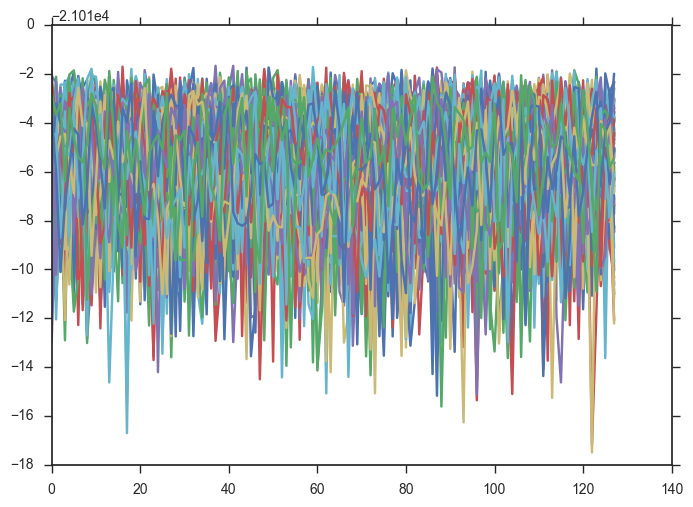

In [10]:
for i in 1:128
    plot(vec(enslnps[i,:]))
end

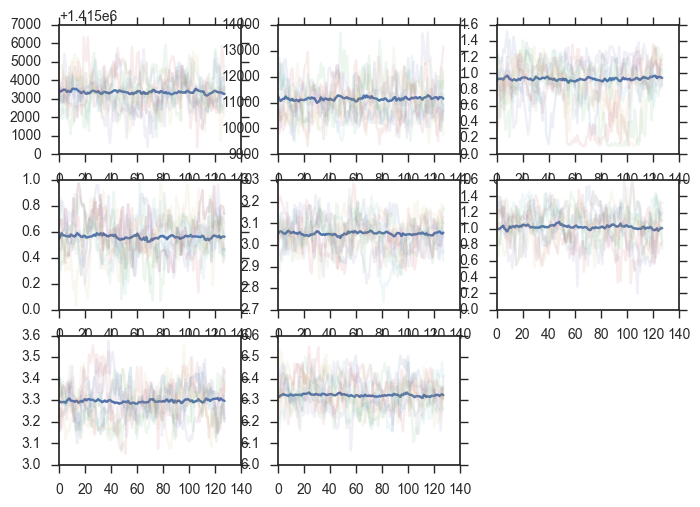

In [14]:
for i in 1:8
    subplot(3,3,i)
    plot(vec(mean(ens[i,:,:], 2)))
    for j in 1:10
        k = rand(1:128)
        plot(vec(ens[i,k,:]), alpha=0.1)
    end
end

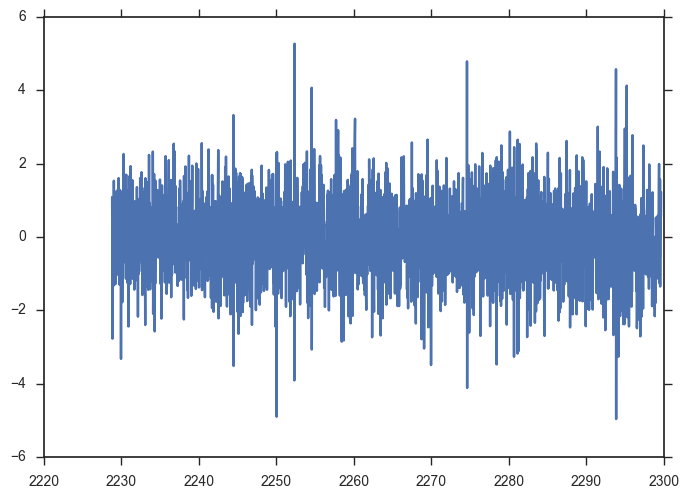

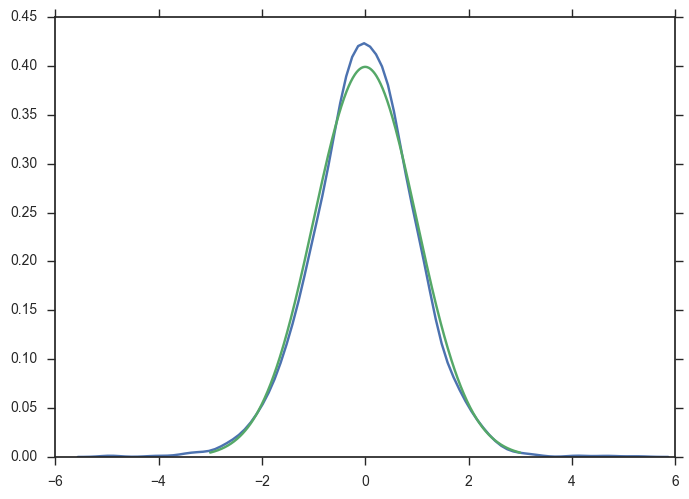

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32ed5ad50>

In [19]:
r, sr = Kalman.residuals(post, ens[:,1,128])
plot(data[:,1], r./sr)
figure()
sns.kdeplot(r./sr)
xs = collect(-3:0.01:3)
plot(xs, 1.0/sqrt(2.0*pi)*exp(-0.5*xs.*xs))

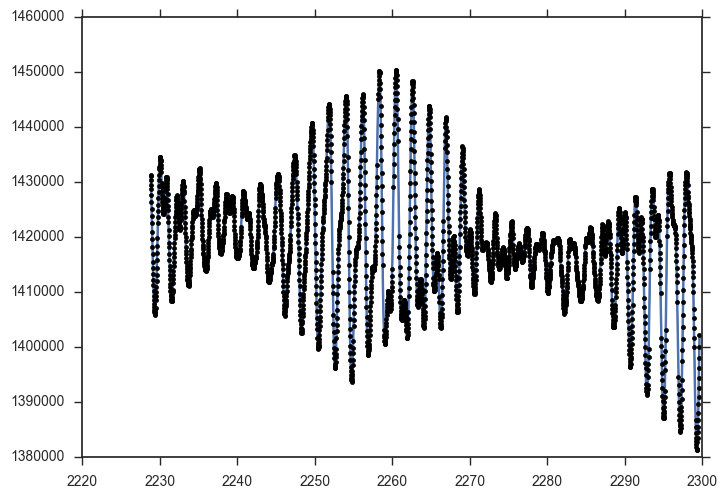

PyObject <matplotlib.collections.PolyCollection object at 0x32f36b390>

In [21]:
ts = sort(vcat(data[:,1], collect(linspace(minimum(data[:,1]), maximum(data[:,1]), 1000))))
ys, vys = Kalman.predict(post, ens[:,1,128], ts)
plot(ts, ys)
plot(data[:,1], data[:,2], ".k")
fill_between(ts, ys+sqrt(vys), ys-sqrt(vys), alpha=0.5)

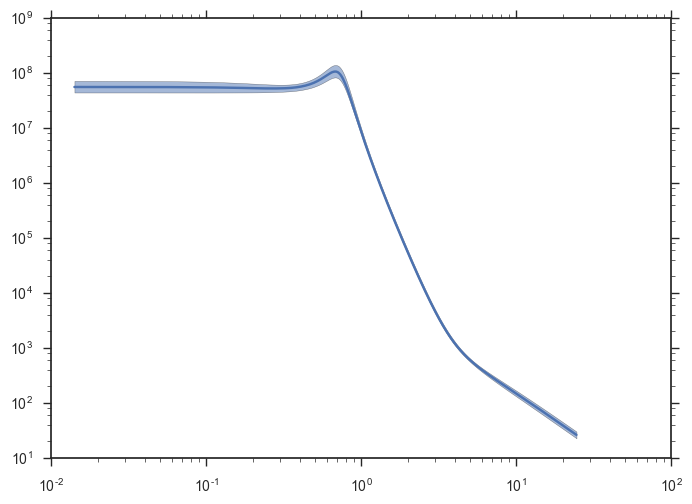

In [25]:
fs = Kalman.psdfreq(post)
psds = Kalman.psd(post, reshape(ens, (size(ens,1), size(ens,2)*size(ens,3))), fs)
mid = zeros(size(psds,1))
low = zeros(size(psds,1))
high = zeros(size(psds,1))
for i in 1:size(psds,1)
    mid[i] = median(vec(psds[i,:]))
    low[i] = quantile(vec(psds[i,:]), 0.16)
    high[i] = quantile(vec(psds[i,:]), 0.84)
end
plot(fs, mid)
fill_between(fs, high, low, alpha=0.5)
xscale("log")
yscale("log")